# TODO

- lightGBMのloss weightをチューニング

# Setting

In [1]:
import sys

import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

root_dir = "../../"
if root_dir not in sys.path:
    sys.path.append(root_dir)
from modules import config as cfg
from modules import utils, preprosess, training, predict, metrics

exp = "exp19"
utils.set_seed(cfg.Params.seed)

# Read data

In [2]:
train, test, submit = utils.get_data(debug_mode=False)

# Preprocessing

## Split fold

In [3]:
train = preprosess.assign_stratified_k_fold(train)

## Convert

In [4]:
# Cityを座標に変換
train = preprosess.convert_to_latlon(train)
test  = preprosess.convert_to_latlon(test)

# testのBankStateの"PR"はtrainにないため，一番多いCAに変換
test = test.with_columns(pl.col("BankState").str.replace("PR", "CA"))

# DisbursementDateとApprovalDateをYear(数値)に変換
cols  = ["DisbursementDate", "ApprovalDate"]
train = preprosess.convert_date_to_year(train, cols)
test  = preprosess.convert_date_to_year(test, cols)

# 金額データの数値化
cols  = ["DisbursementGross",  "GrAppv", "SBA_Appv"]
train = preprosess.convert_money_data(train, cols)
test  = preprosess.convert_money_data(test, cols)

# 一致しているか
eqs = [
    ["State", "BankState"],
]
train = preprosess.add_eq(train, eqs)
test  = preprosess.add_eq(test, eqs)

# 差の計算
diffs = [
    ["DisbursementGross", "GrAppv"],   # 支払われた額 vs 銀行承認額
    ["DisbursementGross", "SBA_Appv"], # 支払われた額 vs SBA承認額
    ["GrAppv", "SBA_Appv"],            # 銀行承認額 vs SBA承認額
]
train = preprosess.add_diff(train, diffs)
test  = preprosess.add_diff(test, diffs)

# DisbursementDateとApprovalDateの差を計算
train = preprosess.add_diff_disbursement_with_approval(train)
test  = preprosess.add_diff_disbursement_with_approval(test)

# 割合の計算
divs = [
    # ["DisbursementGross", "Term"],
    ["GrAppv", "Term"],
    ["SBA_Appv", "Term"],
    ["NoEmp", "Term"],
    # ["DisbursementGross", "NoEmp"],
    # ["GrAppv", "NoEmp"],
    # ["SBA_Appv", "NoEmp"],
    ["DisbursementGross_GrAppv_diff", "Term"],
    ["DisbursementGross_SBA_Appv_diff", "Term"],
    ["GrAppv_SBA_Appv_diff", "Term"],
    # ["DisbursementGross_GrAppv_diff", "NoEmp"],
    # ["DisbursementGross_SBA_Appv_diff", "NoEmp"],
    # ["GrAppv_SBA_Appv_diff", "NoEmp"]
]
train = preprosess.add_div(train, divs)
test  = preprosess.add_div(test, divs)

# Sectorを職業別にする
train = preprosess.unify_same_sector(train)
test  = preprosess.unify_same_sector(test)

## Target encoding

In [5]:
cols = [
    # "Sector",
    "UrbanRural",
    "RevLineCr",
    "LowDoc",
    "FranchiseCode",
]
target_col = "MIS_Status"
train, test = preprosess.target_encoding(train, test, cols)

## Label encoding
CVによるtarget encodingでは同じカテゴリカル変数に異なる値が割り当てられるのでlabel encodingを併用する

In [6]:
cols = ["RevLineCr", "LowDoc"]
train, test = preprosess.label_encoding(train, test, cols)

# Drop columns

In [7]:
# 不要なカラムの削除
del_cols = [
    # 地名系
    "City",
    "State",
    "BankState",
    # d-b-y系
    "DisbursementDate",
    "ApprovalDate",
    "ApprovalFY",
    # ラベルエンコーディング済み
    "RevLineCr",
    "LowDoc",
]
train = train.drop(del_cols)
test  = test.drop(del_cols)

# Training + Tuning

In [9]:
utils.ignore_user_warning()

In [12]:
lgb_params = {
    'verbose': -1,
    'objective': 'binary',
    'metric': 'custom',
    'boosting_type': 'gbdt',
    'seed': cfg.Params.seed,
    'learning_rate': cfg.Params.learning_rate,
}

threshold = 0.5
zero_weights = [0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90]
results_df = pl.DataFrame([
        pl.Series("zero_weight", [], dtype=pl.Float64),
        pl.Series("score", [], dtype=pl.Float64)
])
for zero_weight in zero_weights:
    weight = [zero_weight, 1.0 - zero_weight]
    train = preprosess.add_loss_weight(train, weight)
    oof, models = training.fit_lgbm(train, lgb_params=lgb_params)
    oof_truth = train[cfg.Cols.target].to_numpy()
    oof_hat = predict.predict_class(oof, threshold=threshold)
    cv_score = metrics.macro_f1_score(oof_truth, oof_hat)
    results_df = results_df.vstack(pl.DataFrame({"zero_weight": [zero_weight], "score": [cv_score]}))

--------------------------------------------------------------------------------
START fold 1
Training until validation scores don't improve for 200 rounds
[100]	training's macro_f1: 0.675977	valid_1's macro_f1: 0.680264
Did not meet early stopping. Best iteration is:
[100]	training's macro_f1: 0.675977	valid_1's macro_f1: 0.680264
Time:  5.626[s]
--------------------------------------------------------------------------------
START fold 2
Training until validation scores don't improve for 200 rounds
[100]	training's macro_f1: 0.675815	valid_1's macro_f1: 0.671858
Did not meet early stopping. Best iteration is:
[100]	training's macro_f1: 0.675815	valid_1's macro_f1: 0.671858
Time:  6.779[s]
--------------------------------------------------------------------------------
START fold 3
Training until validation scores don't improve for 200 rounds
[100]	training's macro_f1: 0.677323	valid_1's macro_f1: 0.653755
Did not meet early stopping. Best iteration is:
[100]	training's macro_f1: 0.67

In [13]:
results_df

zero_weight,score
f64,f64
0.8,0.667527
0.81,0.669566
0.82,0.671518
0.83,0.670907
0.84,0.670604
0.85,0.668665
0.86,0.666763
0.87,0.66701
0.88,0.664543


weight = [0.82, 0.18]

In [14]:
weight = [0.82, 0.18]
train = preprosess.add_loss_weight(train, weight)
oof, models = training.fit_lgbm(train, lgb_params=lgb_params)

--------------------------------------------------------------------------------
START fold 1
Training until validation scores don't improve for 200 rounds
[100]	training's macro_f1: 0.678921	valid_1's macro_f1: 0.684461
Did not meet early stopping. Best iteration is:
[100]	training's macro_f1: 0.678921	valid_1's macro_f1: 0.684461
Time:  7.371[s]
--------------------------------------------------------------------------------
START fold 2
Training until validation scores don't improve for 200 rounds
[100]	training's macro_f1: 0.681262	valid_1's macro_f1: 0.67352
Did not meet early stopping. Best iteration is:
[100]	training's macro_f1: 0.681262	valid_1's macro_f1: 0.67352
Time:  7.917[s]
--------------------------------------------------------------------------------
START fold 3
Training until validation scores don't improve for 200 rounds
[100]	training's macro_f1: 0.686827	valid_1's macro_f1: 0.657948
Did not meet early stopping. Best iteration is:
[99]	training's macro_f1: 0.68689

# Predict

In [15]:
threshold = 0.5

In [16]:
pred_prob = predict.predict_probability(models, test)
pred_class = predict.predict_class(pred_prob, threshold=threshold)

## CV score

In [17]:
oof_truth = train[cfg.Cols.target].to_numpy()
oof_hat = predict.predict_class(oof, threshold=threshold)
cv_score = metrics.macro_f1_score(oof_truth, oof_hat)
print(cv_score)

0.6715182916909637


## Check result

### oofとtestの予測値分布を比較してバグを確認

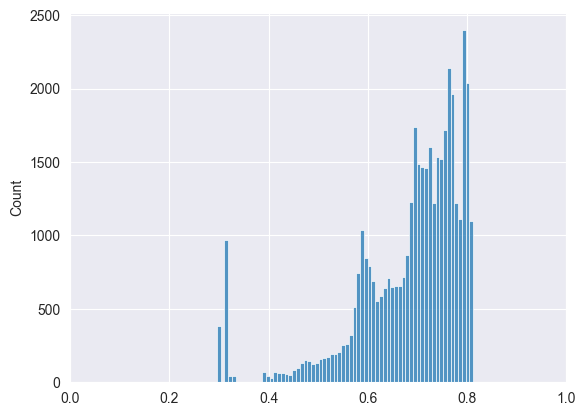

In [18]:
sns.histplot(pred_prob)
plt.xlim(0.0, 1.0)
plt.show()

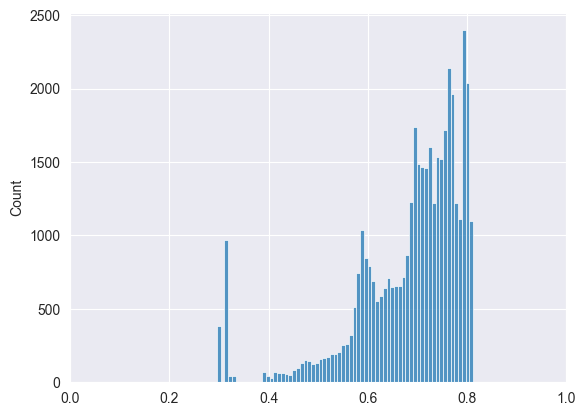

In [19]:
sns.histplot(pred_prob)
plt.xlim(0.0, 1.0)
plt.show()

### 予測値の1の割合を確認

In [20]:
print(pred_class.sum() / len(pred_class))

0.9349059279568875


### oofにおける混同行列を確認

True Negative Rate (0の正解率): 0.33
True Positive Rate (1の正解率): 0.96


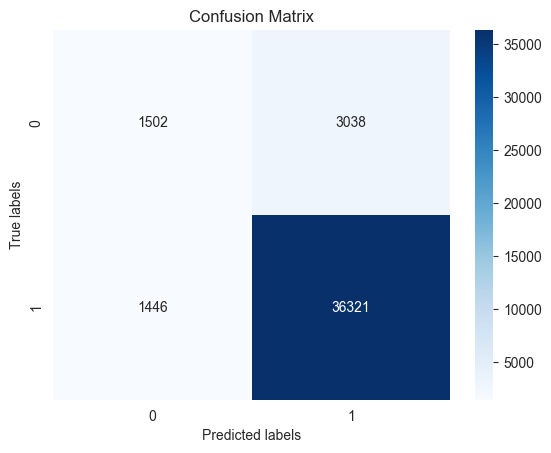

In [21]:
metrics.show_confusion_matrix(oof_truth, oof_hat)

## Submit

In [23]:
submit = submit.with_columns([pl.Series(cfg.Cols.sub_pred, pred_class)])
utils.make_submission(submit, exp, cv_score)